<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>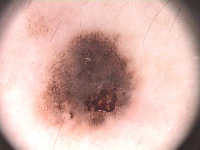</td><td>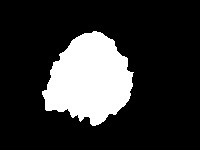</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [73]:
#!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
!unzip /content/drive/MyDrive/ColabNotebooks/medseg.zip

Archive:  /content/drive/MyDrive/ColabNotebooks/medseg.zip
replace PH2Dataset/PH2_Dataset/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: PH2Dataset/PH2_Dataset/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD002/IMD002_lesion/IMD002_lesion.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD002/IMD002_roi/IMD002_R1_Label4.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD002/IMD002_roi/IMD002_R2_Label3.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD003/IMD003_Dermoscopic_Image/IMD003.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD003/IMD003_lesion/IMD003_lesion.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD003/IMD003_roi/IMD003_R1_Label4.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD004/IMD004_Dermoscopic_Image/IMD004.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD004/IMD004_lesion/IMD004_lesion.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD004/IMD004_roi/IMD004_R1_Label4.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD004/I

In [ ]:
!ls

drive  PH2Dataset  sample_data


In [ ]:
#get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [75]:
images = []
lesions = []
from skimage.io import imread
import os
root = '/content/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [76]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [77]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [78]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

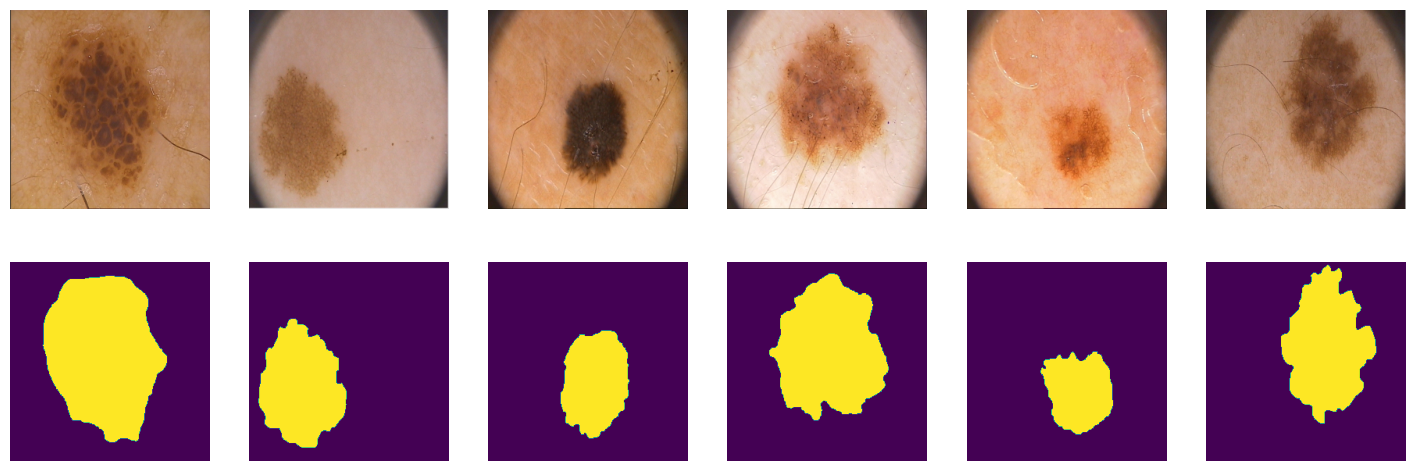

In [79]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [80]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [81]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [82]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [83]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

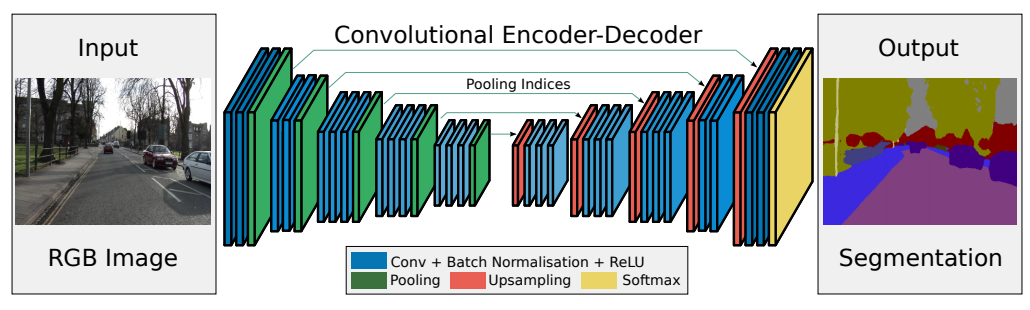

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [85]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        kernel = 3
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel, padding = 1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel, padding = 1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
        )
        self.pool0 = nn.MaxPool2d(2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel, padding = 1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel, padding = 1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel, padding = 1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel, padding = 1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel, padding = 1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel, padding = 1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool2d(2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 256, kernel, padding = 1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel, padding = 1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear') # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(256, 128, kernel, padding = 1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel, padding = 1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
        )
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear') # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel, padding = 1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel, padding = 1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
        )
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear') # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel, padding = 1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel, padding = 1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
        )
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear') # 128 -> 256
        self.dec_conv3 = nn.Conv2d(32, 1, kernel, padding = 1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2)) # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [86]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [87]:
def bce_loss(y_real, y_pred):
    #y_pred = torch.sigmoid(y_pred)
    loss = y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))
    return loss.mean()
    # please don't use nn.BCELoss. write it from scratch

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [113]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            #loss = loss_fn(Y_batch, torch.round(torch.sigmoid(Y_pred))) # forward-pass
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss.item() / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        #X_val, Y_val = X_val.to(device), Y_val.to(device)
        #Y_hat = torch.round(torch.sigmoid(model(X_val)))
        Y_hat = model(X_val.to(device)).detach().to('cpu')
        #loss = loss_fn(Y_val, Y_hat)
        #loss
        #Y_hat, X_val, Y_val = Y_hat.detach().to('cpu'), X_val.to('cpu'), Y_val.to('cpu')

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [89]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [torch.sigmoid(X_batch.to(device)).detach().cpu() for X_batch, _ in data]
    return np.array(Y_pred)

In [90]:
def score_model(model, metric_model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)
        Y_pred = model(X_batch)
        if (metric_model == dice_loss):
          Y_pred = torch.round(Y_pred)
        else:
          Y_pred = torch.sigmoid(Y_pred)
          Y_pred = torch.round(Y_pred)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)

In [ ]:
#for cuda clean
with torch.no_grad():
    torch.cuda.empty_cache()

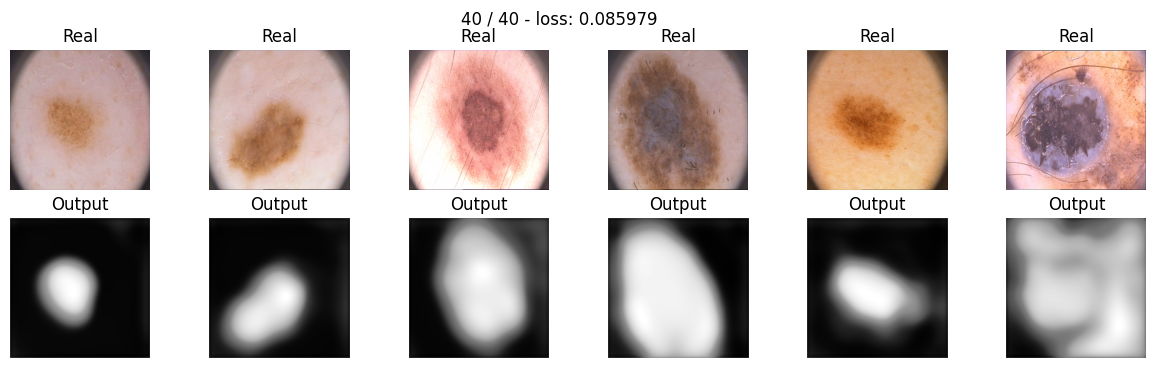

In [ ]:
max_epochs = 40
optim = torch.optim.Adam(model.parameters())
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, bce_loss, iou_pytorch, data_val)

0.7060000002384186

In [ ]:
score_model(model, bce_loss, iou_pytorch, data_tr)

0.8219999819993973

In [ ]:
score_model(model, bce_loss, iou_pytorch, data_ts)

0.6559999585151672

Ответьте себе на вопрос: не переобучается ли моя модель?

Возможно, так как качество на train больше, чем на test

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [91]:
def dice_loss(y_real, y_pred):
    num = torch.sum(torch.sum(torch.sum(y_real*y_pred, 3), 2), 1)
    a1 = torch.sum(torch.sum(torch.sum(y_real*y_real, 3), 2), 1)
    a2 = torch.sum(torch.sum(torch.sum(y_pred*y_pred, 3), 2), 1)
    sq = 2*(num+2e-5)/(a1+a2+2e-5)
    res = 1 - torch.sum(sq)/sq.size(0)
    return res 

Проводим тестирование:

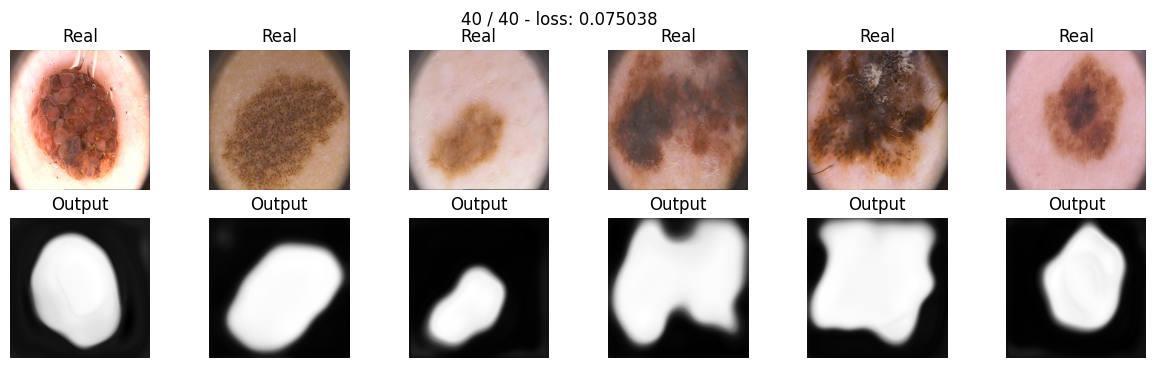

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, dice_loss, iou_pytorch, data_val)

0.6940000057220459

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [92]:
def focal_loss(y_real, y_pred, eps = 1e-6, gamma = 2):
    y_pred = torch.clamp(torch.sigmoid(y_pred), min=eps, max=1.0-eps) # hint: torch.clamp
    return -torch.mean((1-y_pred)**gamma*y_real*torch.log(y_pred)+(1 - y_real)*torch.log(1-y_pred))

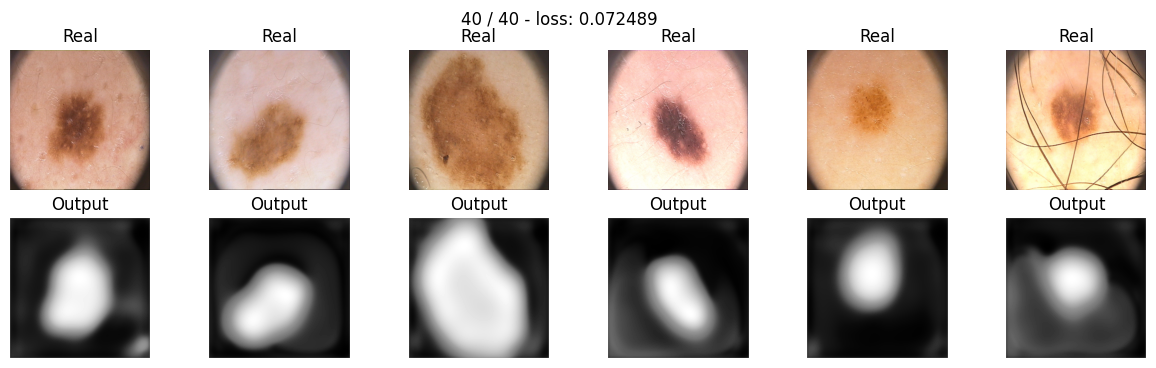

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, focal_loss, iou_pytorch, data_val)

0.6800000071525574

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [93]:
#BCE Soft Targets

def bce_st_loss(y_real, y_pred, smooth_factor = 0.1):
    #y_pred = torch.round(torch.sigmoid(y_pred))
    y_real_st = (1 - y_real) * smooth_factor + y_real * (1 - smooth_factor)
    #y_real_st = y_real/smooth_factor
    loss = y_pred - y_real_st*y_pred + torch.log(1 + torch.exp(-y_pred))
    return loss.mean()
    # please don't use nn.BCELoss. write it from scratch


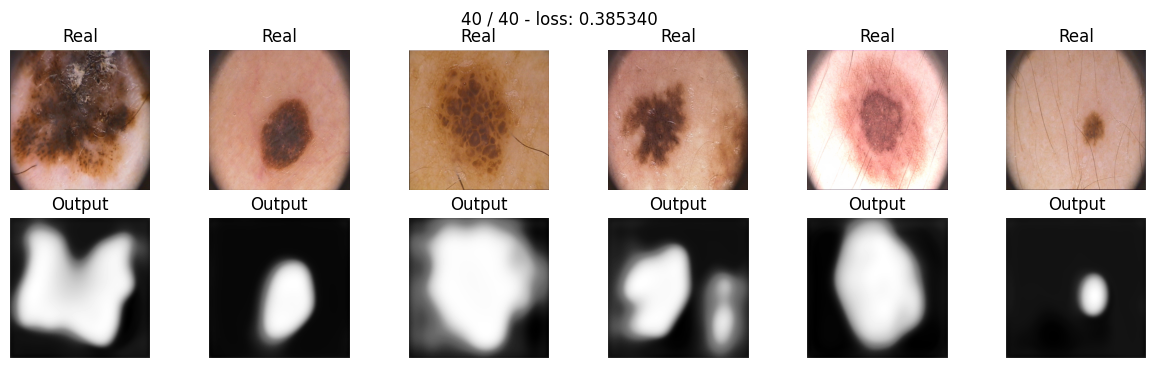

In [ ]:
model_bce_st = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_bce_st.parameters())
train(model_bce_st, optimaizer, bce_st_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_bce_st, bce_st_loss, iou_pytorch, data_val)

0.6739999353885651

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

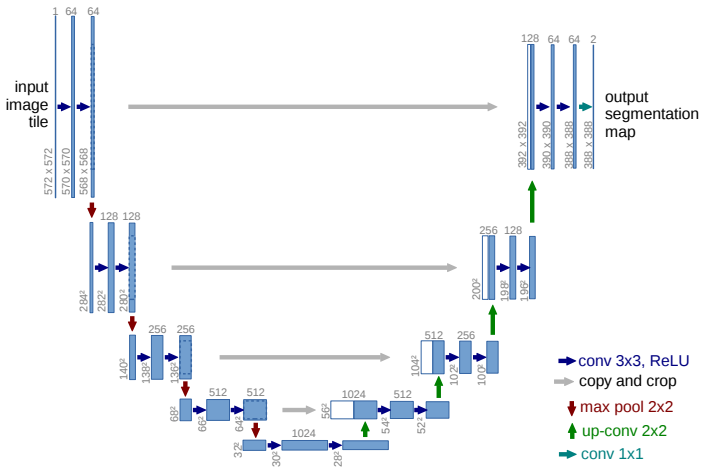

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [94]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        kernel = 3
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(32, 32, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=32),  
        )
        self.pool0 = nn.MaxPool2d(2, stride=2, return_indices=True)  # 256 -> 128 
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(64, 64, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),  
        )
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(128, 128, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128),  
        )
        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True) 
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=256),
            nn.Conv2d(256, 256, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=256),  
        )
        self.pool3 = nn.MaxPool2d(2, stride=2, return_indices=True)  
        # bottleneck
        self.bottleneck_conv = nn.Conv2d(256, 256, 3, padding=1)

        # decoder (upsampling)
        self.unpool0 = nn.MaxUnpool2d(kernel_size = 2, stride=2) 
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(256, 256, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=256),
            nn.Conv2d(256, 128, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128),  
        )
        self.unpool1 = nn.MaxUnpool2d(kernel_size = 2, stride=2)  
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(128, 64, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),  
        )
        self.unpool2 = nn.MaxUnpool2d(kernel_size = 2, stride=2) 
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(64, 32, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=32),  
        )
        self.unpool3 = nn.MaxUnpool2d(kernel_size = 2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(32, 16, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=16),
            nn.Conv2d(16, 1, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=1),  
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0)) 
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        x = self.bottleneck_conv(e3)

        # decoder
        x = self.dec_conv0(self.unpool0(x, ind3))
        x = self.dec_conv1(self.unpool1(x, ind2))
        x = self.dec_conv2(self.unpool2(x, ind1))
        x = self.dec_conv3(self.unpool3(x, ind0))  # no activation
        return x

In [ ]:
unet_model = UNet().to(device)

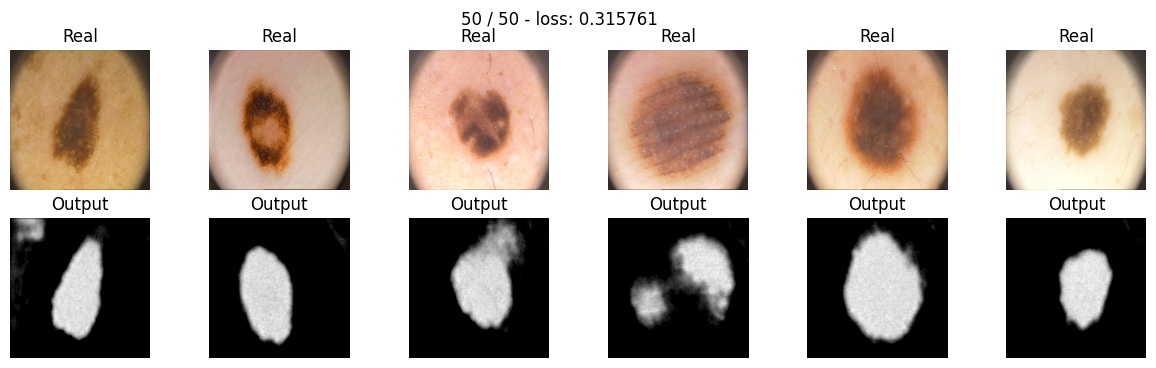

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 50, data_tr, data_val)

In [ ]:
score_model(unet_model, bce_loss, iou_pytorch, data_val)

0.7140000462532043

In [ ]:
score_model(unet_model, bce_loss, iou_pytorch, data_tr)

0.8490000069141388

In [ ]:
score_model(unet_model, bce_loss, iou_pytorch, data_ts)

0.6559999883174896

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [95]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        kernel = 3
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(32, 32, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=32),  
        )
        self.pool0 = nn.Conv2d(32, 32, 3, stride = 2, padding = 1)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(64, 64, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),  
        )
        self.pool1 = nn.Conv2d(64, 64, 3, stride = 2, padding = 1)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(128, 128, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128),  
        )
        self.pool2 = nn.Conv2d(128, 128, 3, stride = 2, padding = 1)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=256),
            nn.Conv2d(256, 256, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=256),  
        )
        self.pool3 = nn.Conv2d(256, 256, 3, stride = 2, padding = 1) 

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(256, 256, 3, padding=1)

        # decoder (upsampling)
        self.unpool0 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(256, 256, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=256),
            nn.Conv2d(256, 128, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128),  
        )
        self.unpool1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(128, 64, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),  
        )
        self.unpool2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(64, 32, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=32),  
        )
        self.unpool3 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(32, 16, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=16),
            nn.Conv2d(16, 1, kernel, padding = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=1),  
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0)) 
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        x = self.bottleneck_conv(e3)

        # decoder
        x = self.dec_conv0(self.unpool0(x))
        x = self.dec_conv1(self.unpool1(x))
        x = self.dec_conv2(self.unpool2(x))
        x = self.dec_conv3(self.unpool3(x))  # no activation
        return x


In [ ]:
unet2_model = UNet2().to(device)


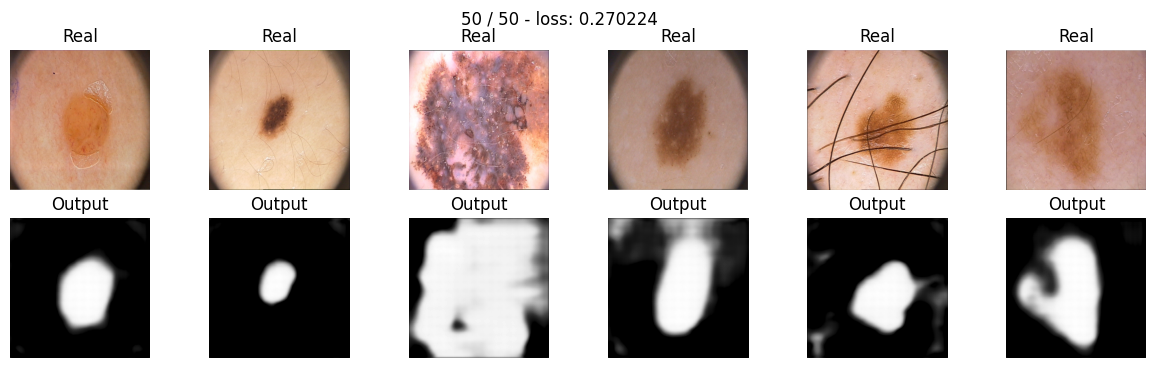

In [ ]:
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 50, data_tr, data_val)

In [ ]:
score_model(unet2_model, bce_loss, iou_pytorch, data_val)

0.6159999966621399

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

Была исправлена функция train, чтобы сохранялся лосс на валидационной выборке:

In [96]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    loss_avg = []
    loss_val = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            #loss = loss_fn(Y_batch, torch.round(torch.sigmoid(Y_pred))) # forward-pass
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss.item() / len(data_tr)
        toc = time()
        #print('loss: %f' % avg_loss)
        loss_avg.append(avg_loss)

        # show intermediate results
        val_loss = 0
        model.eval()  # testing mode
        with torch.no_grad():
            for X_batch, Y_batch in data_val:
                # data to device
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                # forward
                Y_pred = model(X_batch)

                loss = loss_fn(Y_batch, Y_pred)  # forward-pass
                
                # calculate loss to show the user
                val_loss += loss.item() / len(data_val)
        loss_val.append(val_loss)
        
        #Y_hat = model(X_val.to(device)).detach().to('cpu')
        #loss = loss_fn(Y_val, Y_hat)

    return loss_avg, loss_val

Реализуем функцию для построения графиков лоссов моделей:

In [97]:
import seaborn as sns
import pandas as pd 

In [104]:
def graphic_loss(model, loss_fn):
    #model = SegNet().to(device)
    opt = torch.optim.Adam(model.parameters())
    epochs = 50
    loss_tr, loss_val = train(model, opt, loss_fn, epochs, data_tr, data_val)

    #iou_score = score_model(model, loss_fn, iou_pytorch, data_val)

    df = pd.DataFrame([[loss_tr, loss_val]])
    df = pd.DataFrame({'loss_tr':loss_tr, 'loss_val': loss_val})
    print(df)
    ax = sns.lineplot(data=df)
    ax.set_title(loss_fn)
    plt.show()

Построим графики лоссов для SegNet:

* Epoch 1/50
* Epoch 2/50
* Epoch 3/50
* Epoch 4/50
* Epoch 5/50
* Epoch 6/50
* Epoch 7/50
* Epoch 8/50
* Epoch 9/50
* Epoch 10/50
* Epoch 11/50
* Epoch 12/50
* Epoch 13/50
* Epoch 14/50
* Epoch 15/50
* Epoch 16/50
* Epoch 17/50
* Epoch 18/50
* Epoch 19/50
* Epoch 20/50
* Epoch 21/50
* Epoch 22/50
* Epoch 23/50
* Epoch 24/50
* Epoch 25/50
* Epoch 26/50
* Epoch 27/50
* Epoch 28/50
* Epoch 29/50
* Epoch 30/50
* Epoch 31/50
* Epoch 32/50
* Epoch 33/50
* Epoch 34/50
* Epoch 35/50
* Epoch 36/50
* Epoch 37/50
* Epoch 38/50
* Epoch 39/50
* Epoch 40/50
* Epoch 41/50
* Epoch 42/50
* Epoch 43/50
* Epoch 44/50
* Epoch 45/50
* Epoch 46/50
* Epoch 47/50
* Epoch 48/50
* Epoch 49/50
* Epoch 50/50
     loss_tr  loss_val
0   0.610042  0.670737
1   0.391082  0.645470
2   0.305637  0.784425
3   0.293045  0.929820
4   0.258982  1.098285
5   0.231787  0.933212
6   0.254893  1.099538
7   0.231973  0.966342
8   0.226823  0.704210
9   0.207541  0.488070
10  0.203833  0.236438
11  0.204805  0.229949
12  0.2206

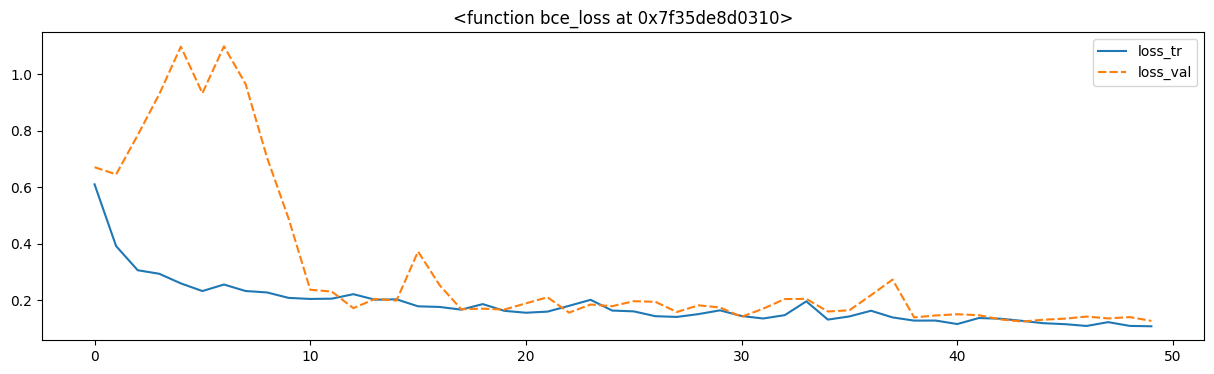

In [ ]:
model1 = SegNet().to(device)
graphic_loss(model1, bce_loss)

* Epoch 1/50
* Epoch 2/50
* Epoch 3/50
* Epoch 4/50
* Epoch 5/50
* Epoch 6/50
* Epoch 7/50
* Epoch 8/50
* Epoch 9/50
* Epoch 10/50
* Epoch 11/50
* Epoch 12/50
* Epoch 13/50
* Epoch 14/50
* Epoch 15/50
* Epoch 16/50
* Epoch 17/50
* Epoch 18/50
* Epoch 19/50
* Epoch 20/50
* Epoch 21/50
* Epoch 22/50
* Epoch 23/50
* Epoch 24/50
* Epoch 25/50
* Epoch 26/50
* Epoch 27/50
* Epoch 28/50
* Epoch 29/50
* Epoch 30/50
* Epoch 31/50
* Epoch 32/50
* Epoch 33/50
* Epoch 34/50
* Epoch 35/50
* Epoch 36/50
* Epoch 37/50
* Epoch 38/50
* Epoch 39/50
* Epoch 40/50
* Epoch 41/50
* Epoch 42/50
* Epoch 43/50
* Epoch 44/50
* Epoch 45/50
* Epoch 46/50
* Epoch 47/50
* Epoch 48/50
* Epoch 49/50
* Epoch 50/50
     loss_tr  loss_val
0   0.711977  0.692718
1   0.561057  0.669638
2   0.503151  0.654124
3   0.457382  0.648469
4   0.446924  0.654815
5   0.426804  0.572975
6   0.427128  0.564399
7   0.428359  0.539931
8   0.423005  0.456511
9   0.411389  0.490934
10  0.408182  0.428707
11  0.424380  0.420171
12  0.4022

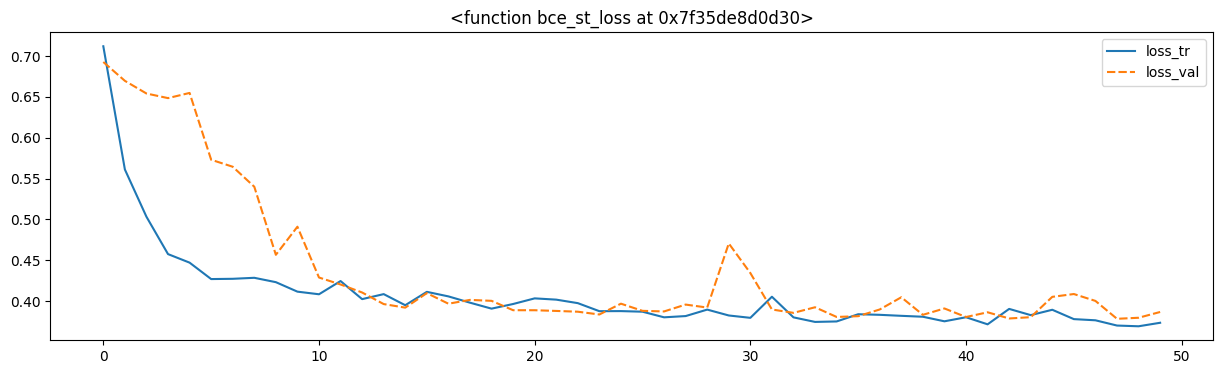

In [ ]:
model2 = SegNet().to(device)
graphic_loss(model2, bce_st_loss)

* Epoch 1/50
* Epoch 2/50
* Epoch 3/50
* Epoch 4/50
* Epoch 5/50
* Epoch 6/50
* Epoch 7/50
* Epoch 8/50
* Epoch 9/50
* Epoch 10/50
* Epoch 11/50
* Epoch 12/50
* Epoch 13/50
* Epoch 14/50
* Epoch 15/50
* Epoch 16/50
* Epoch 17/50
* Epoch 18/50
* Epoch 19/50
* Epoch 20/50
* Epoch 21/50
* Epoch 22/50
* Epoch 23/50
* Epoch 24/50
* Epoch 25/50
* Epoch 26/50
* Epoch 27/50
* Epoch 28/50
* Epoch 29/50
* Epoch 30/50
* Epoch 31/50
* Epoch 32/50
* Epoch 33/50
* Epoch 34/50
* Epoch 35/50
* Epoch 36/50
* Epoch 37/50
* Epoch 38/50
* Epoch 39/50
* Epoch 40/50
* Epoch 41/50
* Epoch 42/50
* Epoch 43/50
* Epoch 44/50
* Epoch 45/50
* Epoch 46/50
* Epoch 47/50
* Epoch 48/50
* Epoch 49/50
* Epoch 50/50
     loss_tr  loss_val
0   0.698059  0.921458
1   0.274209  0.858490
2   0.190929  0.881447
3   0.152494  0.808749
4   0.130249  0.655700
5   0.159743  0.619527
6   0.138202  0.511879
7   0.113977  0.338650
8   0.113928  0.250691
9   0.109815  0.174106
10  0.115197  0.104320
11  0.098626  0.085195
12  0.1049

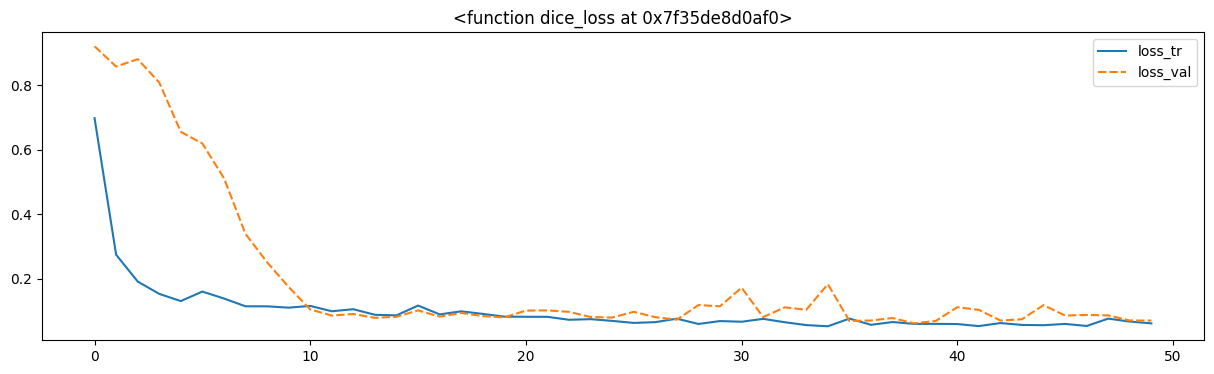

In [ ]:
model3 = SegNet().to(device)
graphic_loss(model3, dice_loss)

* Epoch 1/50
* Epoch 2/50
* Epoch 3/50
* Epoch 4/50
* Epoch 5/50
* Epoch 6/50
* Epoch 7/50
* Epoch 8/50
* Epoch 9/50
* Epoch 10/50
* Epoch 11/50
* Epoch 12/50
* Epoch 13/50
* Epoch 14/50
* Epoch 15/50
* Epoch 16/50
* Epoch 17/50
* Epoch 18/50
* Epoch 19/50
* Epoch 20/50
* Epoch 21/50
* Epoch 22/50
* Epoch 23/50
* Epoch 24/50
* Epoch 25/50
* Epoch 26/50
* Epoch 27/50
* Epoch 28/50
* Epoch 29/50
* Epoch 30/50
* Epoch 31/50
* Epoch 32/50
* Epoch 33/50
* Epoch 34/50
* Epoch 35/50
* Epoch 36/50
* Epoch 37/50
* Epoch 38/50
* Epoch 39/50
* Epoch 40/50
* Epoch 41/50
* Epoch 42/50
* Epoch 43/50
* Epoch 44/50
* Epoch 45/50
* Epoch 46/50
* Epoch 47/50
* Epoch 48/50
* Epoch 49/50
* Epoch 50/50
     loss_tr  loss_val
0   0.478507  0.504462
1   0.314528  0.459717
2   0.249020  0.470308
3   0.197932  0.655496
4   0.197765  0.314174
5   0.155746  0.430158
6   0.164803  0.308090
7   0.153567  0.187598
8   0.130795  0.155956
9   0.129806  0.106492
10  0.122392  0.134658
11  0.126068  0.109422
12  0.1010

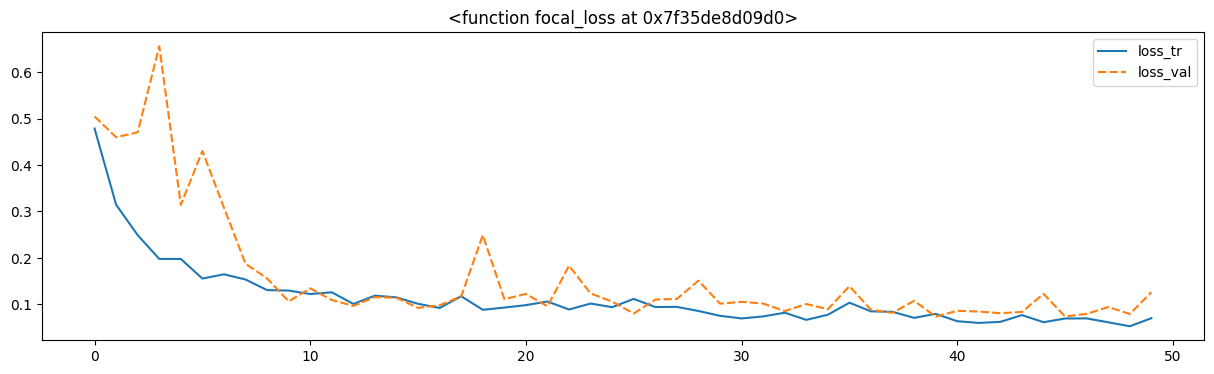

In [ ]:
model4 = SegNet().to(device)
graphic_loss(model4, focal_loss)

In [101]:
print("iou_score, SegNet")
print("with bce_loss:")
print(score_model(model1, bce_loss, iou_pytorch, data_val))
print("with bce_st_loss:")
print(score_model(model2, bce_st_loss, iou_pytorch, data_val))
print("with dice_loss:")
print(score_model(model3, dice_loss, iou_pytorch, data_val))
print("with focal_loss:")
print(score_model(model4, focal_loss, iou_pytorch, data_val))

iou_score, SegNet
with bce_loss:
0.7619999945163727
with bce_st_loss:
0.7399999797344208
with dice_loss:
0.6960000097751617
with focal_loss:
0.6820000112056732


Модели с лоссами BCE и BCE soft targets переобучаются, модели с лоссами Dice loss и focal loss наиболее стабильны. Выберем как наилучшую модель с focal loss.

Построим графики лоссов для Unet:

* Epoch 1/50
* Epoch 2/50
* Epoch 3/50
* Epoch 4/50
* Epoch 5/50
* Epoch 6/50
* Epoch 7/50
* Epoch 8/50
* Epoch 9/50
* Epoch 10/50
* Epoch 11/50
* Epoch 12/50
* Epoch 13/50
* Epoch 14/50
* Epoch 15/50
* Epoch 16/50
* Epoch 17/50
* Epoch 18/50
* Epoch 19/50
* Epoch 20/50
* Epoch 21/50
* Epoch 22/50
* Epoch 23/50
* Epoch 24/50
* Epoch 25/50
* Epoch 26/50
* Epoch 27/50
* Epoch 28/50
* Epoch 29/50
* Epoch 30/50
* Epoch 31/50
* Epoch 32/50
* Epoch 33/50
* Epoch 34/50
* Epoch 35/50
* Epoch 36/50
* Epoch 37/50
* Epoch 38/50
* Epoch 39/50
* Epoch 40/50
* Epoch 41/50
* Epoch 42/50
* Epoch 43/50
* Epoch 44/50
* Epoch 45/50
* Epoch 46/50
* Epoch 47/50
* Epoch 48/50
* Epoch 49/50
* Epoch 50/50
     loss_tr  loss_val
0   0.648383  0.678096
1   0.539906  0.658506
2   0.482469  0.648475
3   0.463968  0.641747
4   0.439534  0.637540
5   0.429418  0.630042
6   0.420628  0.591062
7   0.414826  0.518865
8   0.412720  0.507807
9   0.412252  0.483970
10  0.406275  0.436969
11  0.401034  0.430340
12  0.3975

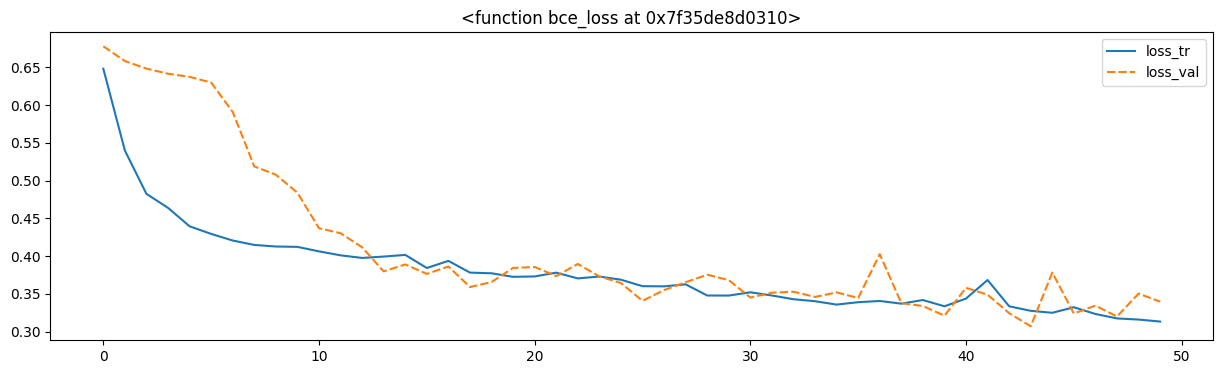

In [ ]:
model5 = UNet().to(device)
graphic_loss(model5, bce_loss)

* Epoch 1/50
* Epoch 2/50
* Epoch 3/50
* Epoch 4/50
* Epoch 5/50
* Epoch 6/50
* Epoch 7/50
* Epoch 8/50
* Epoch 9/50
* Epoch 10/50
* Epoch 11/50
* Epoch 12/50
* Epoch 13/50
* Epoch 14/50
* Epoch 15/50
* Epoch 16/50
* Epoch 17/50
* Epoch 18/50
* Epoch 19/50
* Epoch 20/50
* Epoch 21/50
* Epoch 22/50
* Epoch 23/50
* Epoch 24/50
* Epoch 25/50
* Epoch 26/50
* Epoch 27/50
* Epoch 28/50
* Epoch 29/50
* Epoch 30/50
* Epoch 31/50
* Epoch 32/50
* Epoch 33/50
* Epoch 34/50
* Epoch 35/50
* Epoch 36/50
* Epoch 37/50
* Epoch 38/50
* Epoch 39/50
* Epoch 40/50
* Epoch 41/50
* Epoch 42/50
* Epoch 43/50
* Epoch 44/50
* Epoch 45/50
* Epoch 46/50
* Epoch 47/50
* Epoch 48/50
* Epoch 49/50
* Epoch 50/50
     loss_tr  loss_val
0   0.692528  0.679038
1   0.562202  0.665411
2   0.531885  0.657994
3   0.529429  0.656584
4   0.511018  0.651801
5   0.512763  0.634196
6   0.498578  0.572747
7   0.495941  0.559248
8   0.497673  0.549410
9   0.490235  0.527873
10  0.487582  0.511468
11  0.480507  0.493653
12  0.4801

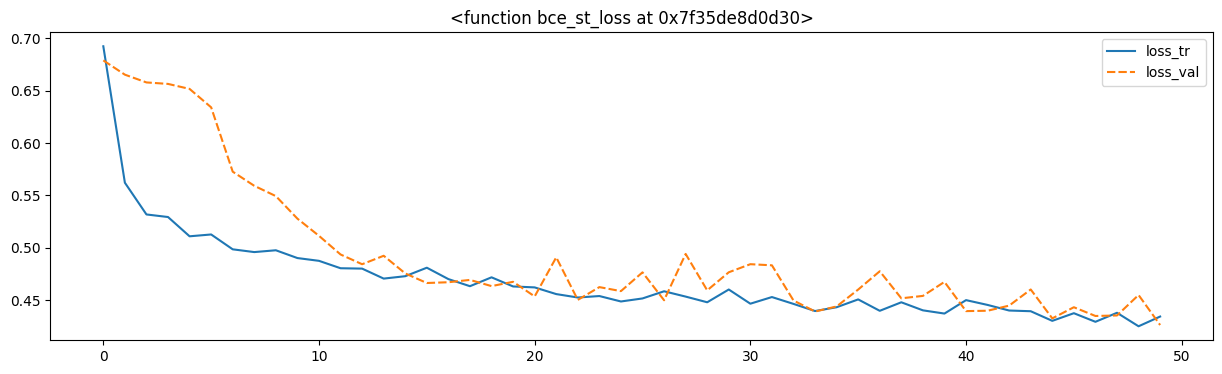

In [ ]:
model6 = UNet().to(device)
graphic_loss(model6, bce_st_loss)

* Epoch 1/50
* Epoch 2/50
* Epoch 3/50
* Epoch 4/50
* Epoch 5/50
* Epoch 6/50
* Epoch 7/50
* Epoch 8/50
* Epoch 9/50
* Epoch 10/50
* Epoch 11/50
* Epoch 12/50
* Epoch 13/50
* Epoch 14/50
* Epoch 15/50
* Epoch 16/50
* Epoch 17/50
* Epoch 18/50
* Epoch 19/50
* Epoch 20/50
* Epoch 21/50
* Epoch 22/50
* Epoch 23/50
* Epoch 24/50
* Epoch 25/50
* Epoch 26/50
* Epoch 27/50
* Epoch 28/50
* Epoch 29/50
* Epoch 30/50
* Epoch 31/50
* Epoch 32/50
* Epoch 33/50
* Epoch 34/50
* Epoch 35/50
* Epoch 36/50
* Epoch 37/50
* Epoch 38/50
* Epoch 39/50
* Epoch 40/50
* Epoch 41/50
* Epoch 42/50
* Epoch 43/50
* Epoch 44/50
* Epoch 45/50
* Epoch 46/50
* Epoch 47/50
* Epoch 48/50
* Epoch 49/50
* Epoch 50/50
     loss_tr  loss_val
0   0.928772  1.166170
1   0.613709  1.405126
2   0.554215  1.497248
3   0.514248  1.515339
4   0.487922  1.457610
5   0.460350  0.523094
6   0.453366  0.769885
7   0.443394  0.530382
8   0.440616  0.545329
9   0.424150  0.503901
10  0.415874  0.462575
11  0.399179  0.417781
12  0.3927

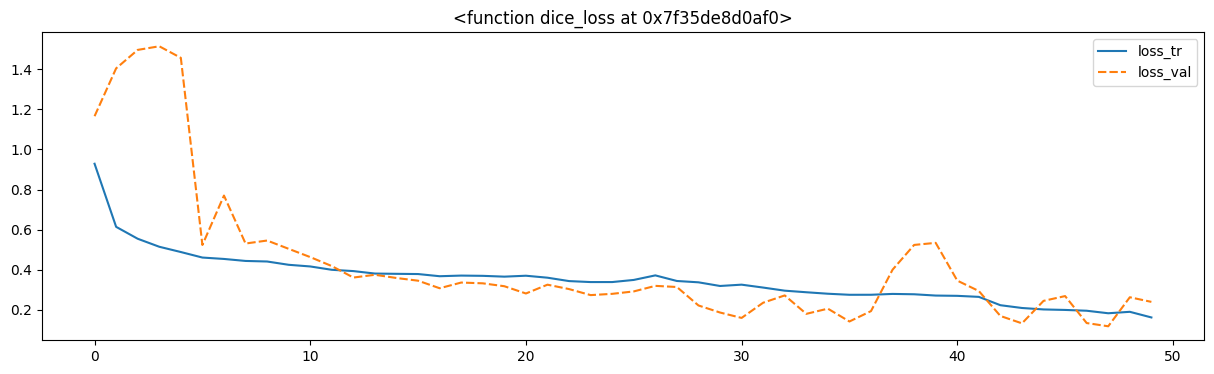

In [ ]:
model7 = UNet().to(device)
graphic_loss(model7, dice_loss)

* Epoch 1/50
* Epoch 2/50
* Epoch 3/50
* Epoch 4/50
* Epoch 5/50
* Epoch 6/50
* Epoch 7/50
* Epoch 8/50
* Epoch 9/50
* Epoch 10/50
* Epoch 11/50
* Epoch 12/50
* Epoch 13/50
* Epoch 14/50
* Epoch 15/50
* Epoch 16/50
* Epoch 17/50
* Epoch 18/50
* Epoch 19/50
* Epoch 20/50
* Epoch 21/50
* Epoch 22/50
* Epoch 23/50
* Epoch 24/50
* Epoch 25/50
* Epoch 26/50
* Epoch 27/50
* Epoch 28/50
* Epoch 29/50
* Epoch 30/50
* Epoch 31/50
* Epoch 32/50
* Epoch 33/50
* Epoch 34/50
* Epoch 35/50
* Epoch 36/50
* Epoch 37/50
* Epoch 38/50
* Epoch 39/50
* Epoch 40/50
* Epoch 41/50
* Epoch 42/50
* Epoch 43/50
* Epoch 44/50
* Epoch 45/50
* Epoch 46/50
* Epoch 47/50
* Epoch 48/50
* Epoch 49/50
* Epoch 50/50
     loss_tr  loss_val
0   0.532522  0.500704
1   0.416961  0.473319
2   0.366642  0.452326
3   0.350563  0.441651
4   0.345631  0.436425
5   0.344923  0.430208
6   0.340125  0.411078
7   0.328154  0.388755
8   0.325300  0.362427
9   0.322296  0.329185
10  0.321159  0.315913
11  0.317196  0.320404
12  0.3074

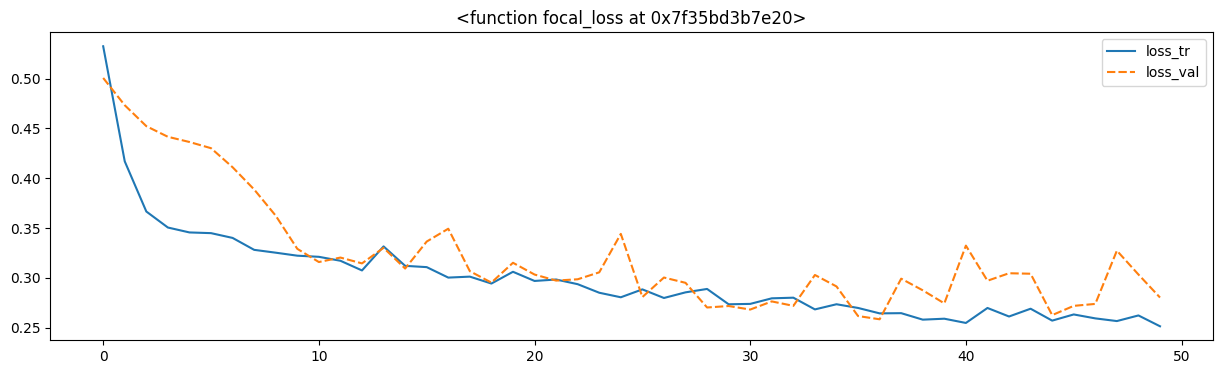

In [72]:
model8 = UNet().to(device)
graphic_loss(model8, focal_loss)

In [112]:
print("iou_score, UNet")
print("with bce_loss:")
print(score_model(model5, bce_loss, iou_pytorch, data_val))
print("with bce_st_loss:")
print(score_model(model6, bce_st_loss, iou_pytorch, data_val))
print("with dice_loss:")
print(score_model(model7, dice_loss, iou_pytorch, data_val))
print("with focal_loss:")
print(score_model(model8, focal_loss, iou_pytorch, data_val))

iou_score, UNet
with bce_loss:
0.6839999854564667
with bce_st_loss:
0.7619999945163727
with dice_loss:
0.5399999618530273
with focal_loss:
0.703999936580658


Модели с лоссами dice_loss и focal loss переобучаются, модели с лоссами BCE loss и BCE soft targets наиболее стабильны (BCE лучше). Выберем как наилучшую модель с BCE loss (более приближённые графики).

* Epoch 1/50
* Epoch 2/50
* Epoch 3/50
* Epoch 4/50
* Epoch 5/50
* Epoch 6/50
* Epoch 7/50
* Epoch 8/50
* Epoch 9/50
* Epoch 10/50
* Epoch 11/50
* Epoch 12/50
* Epoch 13/50
* Epoch 14/50
* Epoch 15/50
* Epoch 16/50
* Epoch 17/50
* Epoch 18/50
* Epoch 19/50
* Epoch 20/50
* Epoch 21/50
* Epoch 22/50
* Epoch 23/50
* Epoch 24/50
* Epoch 25/50
* Epoch 26/50
* Epoch 27/50
* Epoch 28/50
* Epoch 29/50
* Epoch 30/50
* Epoch 31/50
* Epoch 32/50
* Epoch 33/50
* Epoch 34/50
* Epoch 35/50
* Epoch 36/50
* Epoch 37/50
* Epoch 38/50
* Epoch 39/50
* Epoch 40/50
* Epoch 41/50
* Epoch 42/50
* Epoch 43/50
* Epoch 44/50
* Epoch 45/50
* Epoch 46/50
* Epoch 47/50
* Epoch 48/50
* Epoch 49/50
* Epoch 50/50
     loss_tr  loss_val
0   0.640920  0.680316
1   0.503438  0.662661
2   0.465002  0.653734
3   0.432540  0.647596
4   0.432790  0.576642
5   0.435778  0.473356
6   0.412135  0.445432
7   0.409819  0.446349
8   0.404598  0.427133
9   0.408503  0.409991
10  0.399763  0.399112
11  0.395217  0.423017
12  0.3999

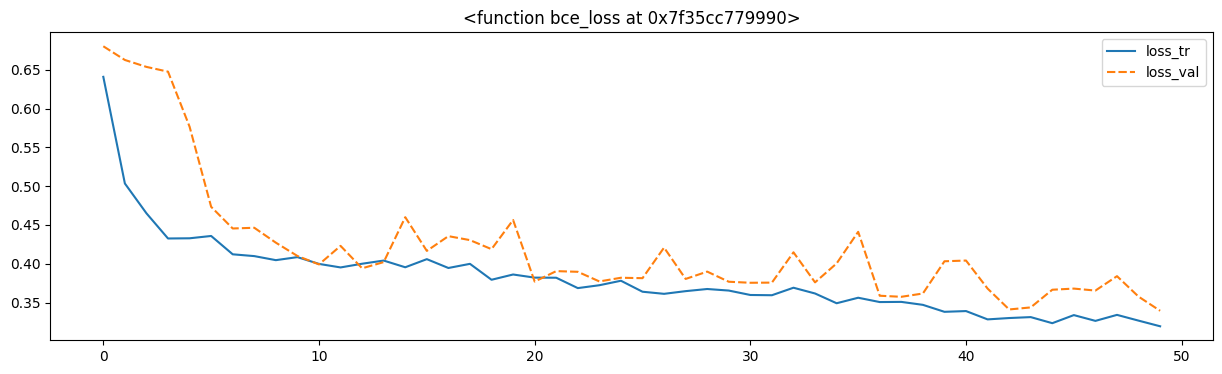

In [105]:
model9 = UNet2().to(device)
graphic_loss(model9, bce_loss)

* Epoch 1/50
* Epoch 2/50
* Epoch 3/50
* Epoch 4/50
* Epoch 5/50
* Epoch 6/50
* Epoch 7/50
* Epoch 8/50
* Epoch 9/50
* Epoch 10/50
* Epoch 11/50
* Epoch 12/50
* Epoch 13/50
* Epoch 14/50
* Epoch 15/50
* Epoch 16/50
* Epoch 17/50
* Epoch 18/50
* Epoch 19/50
* Epoch 20/50
* Epoch 21/50
* Epoch 22/50
* Epoch 23/50
* Epoch 24/50
* Epoch 25/50
* Epoch 26/50
* Epoch 27/50
* Epoch 28/50
* Epoch 29/50
* Epoch 30/50
* Epoch 31/50
* Epoch 32/50
* Epoch 33/50
* Epoch 34/50
* Epoch 35/50
* Epoch 36/50
* Epoch 37/50
* Epoch 38/50
* Epoch 39/50
* Epoch 40/50
* Epoch 41/50
* Epoch 42/50
* Epoch 43/50
* Epoch 44/50
* Epoch 45/50
* Epoch 46/50
* Epoch 47/50
* Epoch 48/50
* Epoch 49/50
* Epoch 50/50
     loss_tr  loss_val
0   0.666532  0.682177
1   0.561553  0.670553
2   0.537987  0.666482
3   0.530022  0.660588
4   0.526549  0.607665
5   0.499265  0.578912
6   0.509971  0.583720
7   0.496883  0.536138
8   0.497079  0.527203
9   0.497716  0.528270
10  0.492946  0.505314
11  0.485619  0.500325
12  0.4924

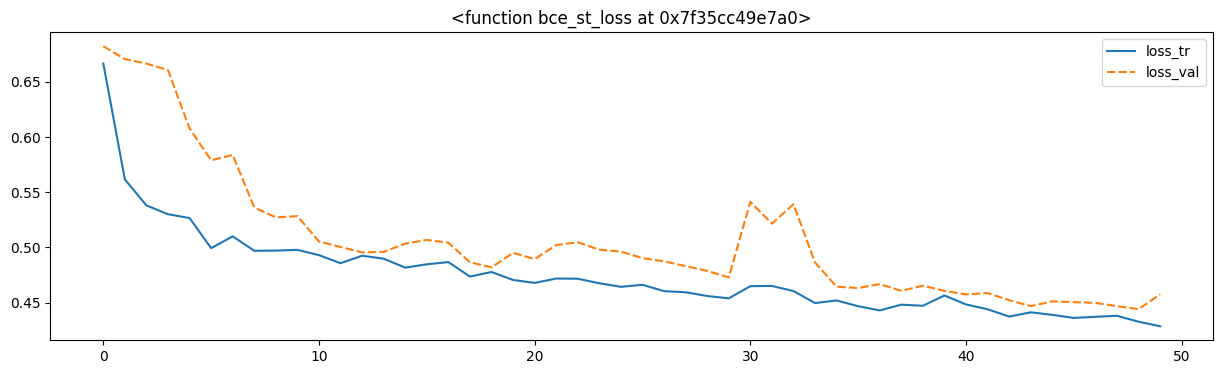

In [106]:
model10 = UNet2().to(device)
graphic_loss(model10, bce_st_loss)

* Epoch 1/50
* Epoch 2/50
* Epoch 3/50
* Epoch 4/50
* Epoch 5/50
* Epoch 6/50
* Epoch 7/50
* Epoch 8/50
* Epoch 9/50
* Epoch 10/50
* Epoch 11/50
* Epoch 12/50
* Epoch 13/50
* Epoch 14/50
* Epoch 15/50
* Epoch 16/50
* Epoch 17/50
* Epoch 18/50
* Epoch 19/50
* Epoch 20/50
* Epoch 21/50
* Epoch 22/50
* Epoch 23/50
* Epoch 24/50
* Epoch 25/50
* Epoch 26/50
* Epoch 27/50
* Epoch 28/50
* Epoch 29/50
* Epoch 30/50
* Epoch 31/50
* Epoch 32/50
* Epoch 33/50
* Epoch 34/50
* Epoch 35/50
* Epoch 36/50
* Epoch 37/50
* Epoch 38/50
* Epoch 39/50
* Epoch 40/50
* Epoch 41/50
* Epoch 42/50
* Epoch 43/50
* Epoch 44/50
* Epoch 45/50
* Epoch 46/50
* Epoch 47/50
* Epoch 48/50
* Epoch 49/50
* Epoch 50/50
     loss_tr  loss_val
0   0.986015  1.143700
1   0.752813  1.294808
2   0.599323  1.440487
3   0.533111  1.505877
4   0.495764  1.391981
5   0.504256  0.632782
6   0.499129  0.877101
7   0.490002  0.757511
8   0.461834  0.607365
9   0.445130  0.749796
10  0.430335  0.632814
11  0.420780  0.518309
12  0.4223

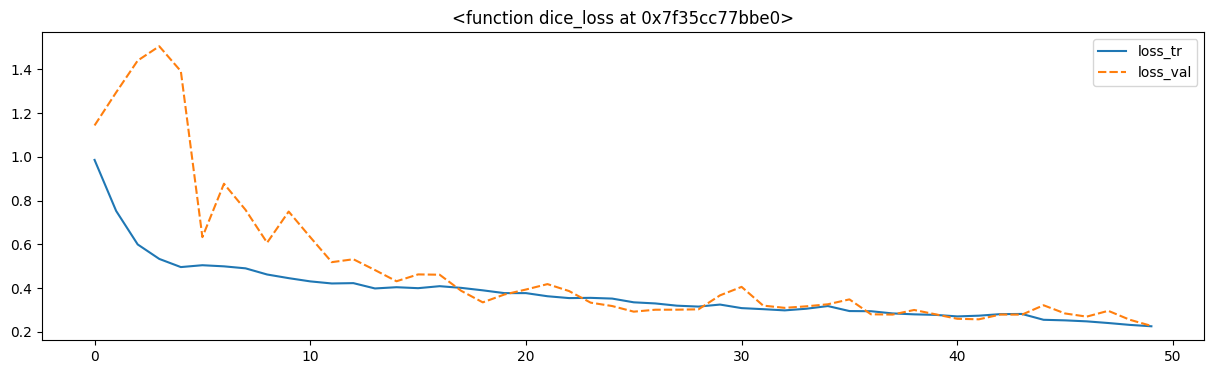

In [107]:
model11 = UNet2().to(device)
graphic_loss(model11, dice_loss)

* Epoch 1/50
* Epoch 2/50
* Epoch 3/50
* Epoch 4/50
* Epoch 5/50
* Epoch 6/50
* Epoch 7/50
* Epoch 8/50
* Epoch 9/50
* Epoch 10/50
* Epoch 11/50
* Epoch 12/50
* Epoch 13/50
* Epoch 14/50
* Epoch 15/50
* Epoch 16/50
* Epoch 17/50
* Epoch 18/50
* Epoch 19/50
* Epoch 20/50
* Epoch 21/50
* Epoch 22/50
* Epoch 23/50
* Epoch 24/50
* Epoch 25/50
* Epoch 26/50
* Epoch 27/50
* Epoch 28/50
* Epoch 29/50
* Epoch 30/50
* Epoch 31/50
* Epoch 32/50
* Epoch 33/50
* Epoch 34/50
* Epoch 35/50
* Epoch 36/50
* Epoch 37/50
* Epoch 38/50
* Epoch 39/50
* Epoch 40/50
* Epoch 41/50
* Epoch 42/50
* Epoch 43/50
* Epoch 44/50
* Epoch 45/50
* Epoch 46/50
* Epoch 47/50
* Epoch 48/50
* Epoch 49/50
* Epoch 50/50
     loss_tr  loss_val
0   0.514178  0.492310
1   0.365448  0.455547
2   0.359319  0.442030
3   0.361409  0.436814
4   0.352194  0.435060
5   0.340965  0.432816
6   0.352807  0.409970
7   0.335954  0.377357
8   0.333867  0.358130
9   0.330339  0.357248
10  0.324954  0.349193
11  0.325696  0.328149
12  0.3215

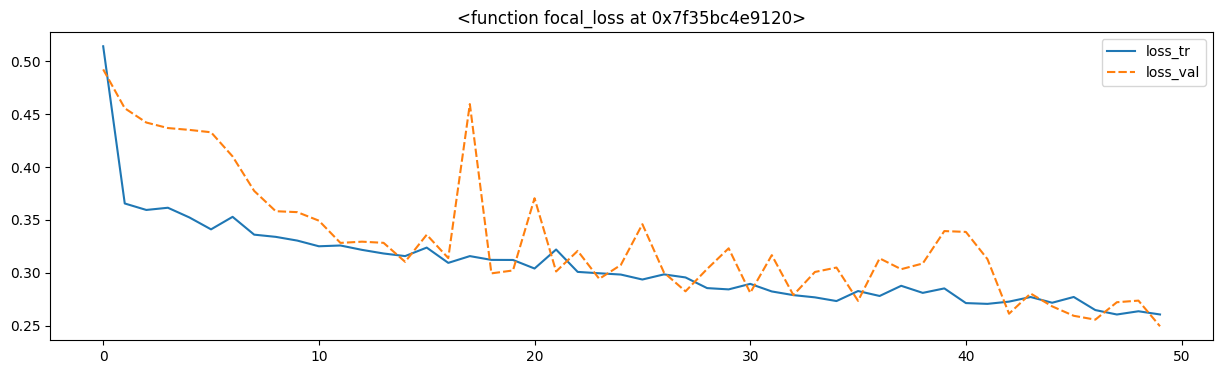

In [108]:
model12 = UNet2().to(device)
graphic_loss(model12, focal_loss)

In [111]:
print("iou_score, UNet2")
print("with bce_loss:")
print(score_model(model9, bce_loss, iou_pytorch, data_val))
print("with bce_st_loss:")
print(score_model(model10, bce_st_loss, iou_pytorch, data_val))
print("with dice_loss:")
print(score_model(model11, dice_loss, iou_pytorch, data_val))
print("with focal_loss:")
print(score_model(model12, focal_loss, iou_pytorch, data_val))

iou_score, UNet2
with bce_loss:
0.7240000069141388
with bce_st_loss:
0.6880000233650208
with dice_loss:
0.6220000088214874
with focal_loss:
0.7179999649524689


Модели с лоссом focal loss переобучается, модели с лоссом dice_loss наиболее стабильна. Выберем как наилучшую модель с dice loss (более приближённые графики).

Сравним лучшие модели:

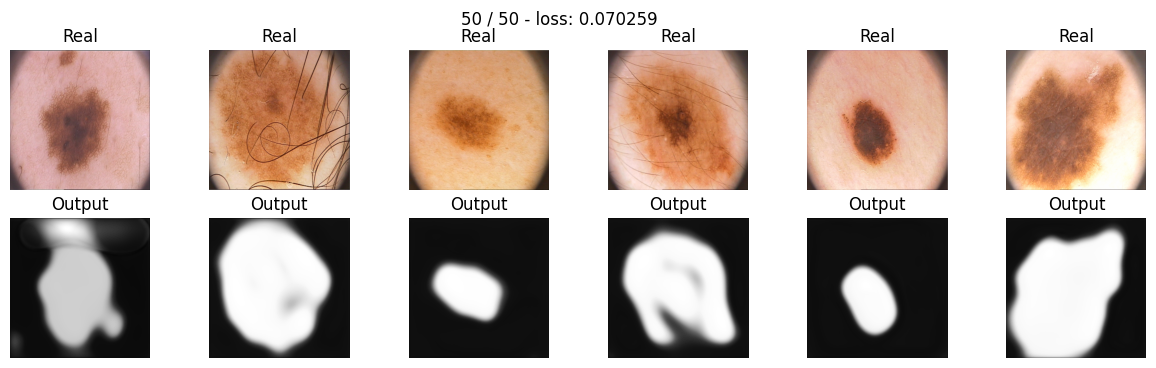

In [ ]:
segnet_best = SegNet().to(device)
max_epochs = 50
optimaizer = torch.optim.Adam(segnet_best.parameters())
train(segnet_best, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(segnet_best, dice_loss, iou_pytorch, data_ts)

0.6499999761581421

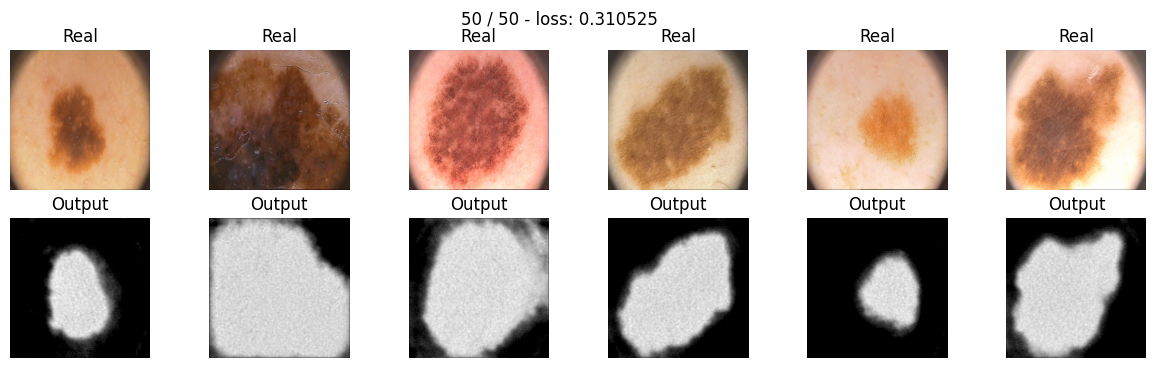

In [ ]:
unet_best = UNet().to(device)
max_epochs = 50
optimaizer = torch.optim.Adam(unet_best.parameters())
train(unet_best, optimaizer, bce_loss, max_epochs, data_tr, data_val)

In [114]:
score_model(unet_best, bce_loss, iou_pytorch, data_ts)

0.6960000097751617

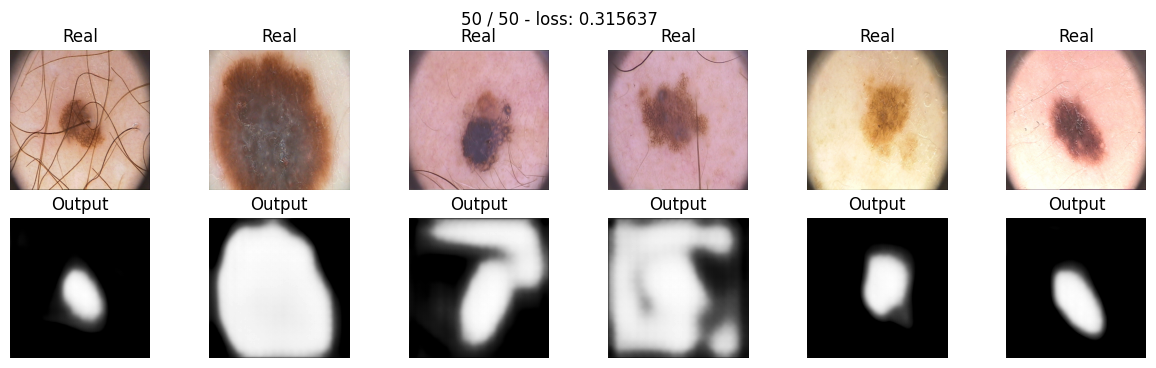

In [119]:
unet2_best = UNet2().to(device)
max_epochs = 50
optimaizer = torch.optim.Adam(unet2_best.parameters())
train(unet2_best, optimaizer, bce_loss, max_epochs, data_tr, data_val)

In [120]:
score_model(unet2_best, bce_loss, iou_pytorch, data_ts)

0.5119999796152115

Самая лучшая модель - Unet с лоссом BCE.